# **Retraining only using informative features**

## Data and Model Import

In [ ]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
import shap
from datetime import datetime

from utils import *


datasets_folder = './datasets'
models_folder = './models'
figsize = (20,4)
verbosity = 0

tf.config.set_visible_devices([], 'GPU')
print(tf.config.list_physical_devices('GPU'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


d:\GitHub\AII-project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[]


In [ ]:
pollution_data = read_and_preprocess_dataset(datasets_folder, 'pollution', v=verbosity)
traffic_data = read_and_preprocess_dataset(datasets_folder, 'traffic', v=verbosity, radius=2)
weather_data = read_and_preprocess_dataset(datasets_folder, 'weather', v=verbosity)

stations = list(pollution_data.keys())

In [ ]:
station_data = {}
date_encoding = 'radial_months-sin-cos_days_hours'

for station in stations:
    station_data[station] = prepare_station_data_for_training(
        pollution_data[station], 
        traffic_data[station], 
        weather_data, 
        encoding_method=date_encoding,
        # weather merging parameters:
        aggregations = DEFAULT_AGGREGATIONS,
        max_min_columns = DEFAULT_MAX_MIN_COLUMNS, 
        # traffic merging parameters:
        bin_size = 3,
        offset = 0
        # bin_size = 8,
        # offset = 2
    )
    
    print(f'Station {station} agents: ',', '.join(list(station_data[station].keys())))

n_hour_features = len(station_data['GIARDINI MARGHERITA']['NO2'].columns) - 1 # -1 because Agent_value is the target
n_daily_features = len(station_data['GIARDINI MARGHERITA']['PM2.5'].columns) - 1 # -1 because Agent_value is the target
print(f'Total number of hourly features: {n_hour_features}')
print(f'Total number of daily features: {n_daily_features}')
agents = list(set(agent for station in stations for agent in station_data[station].keys()))

Station GIARDINI MARGHERITA agents:  NO2, O3, PM10, PM2.5
Station PORTA SAN FELICE agents:  C6H6, CO, NO2, PM10, PM2.5
Station VIA CHIARINI agents:  NO2, O3, PM10
Total number of hourly features: 24
Total number of daily features: 33


## New training and test sets

We list all the features that doesnt seem to help the model or that are not really coherent.

In [ ]:
shap_feature_importance = {
'GIARDINI MARGHERITA': {
       'NO2': ['Traffic_value', 'W_VEC_DIR', 'W_SCAL_INT', 'TAVG', 'RAD', 'month_rbf_1', 'RHAVG', 'month_rbf_2', 'hour_sin', 'hour_cos', 'month_rbf_12', 'month_rbf_11', 'day_cos', 'day_sin', 'month_rbf_9', 'month_rbf_5', 'month_rbf_8', 'month_rbf_7', 'month_rbf_6', 'month_rbf_3', 'LEAFW', 'month_rbf_4', 'month_rbf_10', 'PREC' ],
       'O3': ['TAVG', 'RHAVG', 'W_SCAL_INT', 'RAD', 'W_VEC_DIR', 'hour_sin', 'month_rbf_10', 'day_cos', 'Traffic_value', 'day_sin', 'hour_cos', 'month_rbf_9', 'month_rbf_1', 'LEAFW', 'month_rbf_6', 'month_rbf_11', 'month_rbf_5', 'month_rbf_2', 'month_rbf_8', 'month_rbf_12', 'month_rbf_7', 'month_rbf_3', 'month_rbf_4', 'PREC' ],
       'PM10': ['LEAFW', 'W_SCAL_INT', 'RHAVG_MIN', 'month_rbf_3', 'month_rbf_2', 'TAVG_MAX', 'month_rbf_1', 'RHAVG', 'TAVG', 'day_cos', 'day_sin', 'TAVG_MIN', 'month_rbf_12', 'month_rbf_11', 'RHAVG_MAX', 'month_rbf_8', 'PREC', 'month_rbf_10', 'RAD', 'W_VEC_DIR', 'month_rbf_7', 'month_rbf_5', 'month_rbf_4', 'month_rbf_9', 'month_rbf_6', 'Traffic_0-2', 'Traffic_9-11', 'Traffic_12-14', 'Traffic_3-5', 'Traffic_6-8', 'Traffic_21-0', 'Traffic_18-20', 'Traffic_15-17' ],
       'PM2.5': ['W_SCAL_INT', 'LEAFW', 'month_rbf_2', 'RHAVG_MIN', 'day_sin', 'RHAVG', 'month_rbf_3', 'month_rbf_12', 'TAVG_MAX', 'day_cos', 'month_rbf_1', 'TAVG_MIN', 'PREC', 'month_rbf_5', 'RHAVG_MAX', 'month_rbf_10', 'TAVG', 'month_rbf_8', 'month_rbf_11', 'W_VEC_DIR', 'month_rbf_6', 'RAD', 'month_rbf_4', 'month_rbf_7', 'month_rbf_9', 'Traffic_15-17', 'Traffic_21-0', 'Traffic_6-8', 'Traffic_3-5', 'Traffic_0-2', 'Traffic_18-20', 'Traffic_9-11', 'Traffic_12-14' ],
    },
'PORTA SAN FELICE': {
       'C6H6': ['Traffic_value', 'W_SCAL_INT', 'month_rbf_4', 'month_rbf_5', 'month_rbf_6', 'month_rbf_10', 'month_rbf_7', 'RAD', 'month_rbf_8', 'W_VEC_DIR', 'hour_cos', 'PREC', 'month_rbf_11', 'TAVG', 'day_cos', 'RHAVG', 'month_rbf_12', 'LEAFW', 'month_rbf_9', 'hour_sin', 'month_rbf_3', 'day_sin', 'month_rbf_1', 'month_rbf_2' ],
       'CO': ['TAVG', 'Traffic_value', 'hour_sin', 'W_SCAL_INT', 'month_rbf_12', 'month_rbf_1', 'month_rbf_7', 'month_rbf_8', 'hour_cos', 'month_rbf_6', 'month_rbf_9', 'month_rbf_4', 'day_sin', 'month_rbf_2', 'month_rbf_11', 'RAD', 'LEAFW', 'day_cos', 'month_rbf_3', 'month_rbf_5', 'RHAVG', 'month_rbf_10', 'PREC', 'W_VEC_DIR' ],
       'NO2': ['Traffic_value', 'hour_sin', 'hour_cos', 'TAVG', 'W_SCAL_INT', 'month_rbf_7', 'month_rbf_1', 'RAD', 'month_rbf_12', 'month_rbf_3', 'month_rbf_10', 'W_VEC_DIR', 'month_rbf_2', 'month_rbf_11', 'day_sin', 'day_cos', 'RHAVG', 'LEAFW', 'month_rbf_6', 'month_rbf_4', 'month_rbf_9', 'month_rbf_8', 'month_rbf_5', 'PREC' ],
       'PM10': ['LEAFW', 'W_SCAL_INT', 'month_rbf_2', 'RHAVG_MIN', 'month_rbf_1', 'day_sin', 'TAVG_MAX', 'day_cos', 'RHAVG', 'TAVG', 'month_rbf_3', 'RAD', 'PREC', 'month_rbf_12', 'TAVG_MIN', 'month_rbf_8', 'month_rbf_11', 'month_rbf_7', 'Traffic_6-8', 'month_rbf_10', 'month_rbf_6', 'W_VEC_DIR', 'RHAVG_MAX', 'month_rbf_5', 'month_rbf_9', 'month_rbf_4', 'Traffic_0-2', 'Traffic_3-5', 'Traffic_12-14', 'Traffic_21-0', 'Traffic_15-17', 'Traffic_9-11', 'Traffic_18-20' ],
       'PM2.5': ['W_SCAL_INT', 'LEAFW', 'month_rbf_2', 'RHAVG_MIN', 'day_sin', 'month_rbf_1', 'RHAVG', 'month_rbf_3', 'month_rbf_12', 'day_cos', 'TAVG_MIN', 'PREC', 'month_rbf_11', 'TAVG_MAX', 'W_VEC_DIR', 'month_rbf_10', 'TAVG', 'RHAVG_MAX', 'month_rbf_8', 'Traffic_6-8', 'month_rbf_6', 'month_rbf_5', 'month_rbf_7', 'RAD', 'month_rbf_4', 'Traffic_0-2', 'month_rbf_9', 'Traffic_21-0', 'Traffic_3-5', 'Traffic_15-17', 'Traffic_18-20', 'Traffic_12-14', 'Traffic_9-11' ],
    },
'VIA CHIARINI': {
       'NO2': ['Traffic_value', 'hour_cos', 'RHAVG', 'TAVG', 'hour_sin', 'month_rbf_1', 'W_SCAL_INT', 'month_rbf_12', 'month_rbf_2', 'month_rbf_3', 'W_VEC_DIR', 'month_rbf_11', 'month_rbf_6', 'month_rbf_8', 'day_cos', 'RAD', 'day_sin', 'month_rbf_4', 'month_rbf_5', 'month_rbf_9', 'month_rbf_7', 'LEAFW', 'month_rbf_10', 'PREC' ],
       'O3': ['PREC', 'hour_cos', 'month_rbf_8', 'TAVG', 'W_SCAL_INT', 'month_rbf_7', 'month_rbf_2', 'month_rbf_11', 'month_rbf_6', 'RAD', 'RHAVG', 'day_cos', 'Traffic_value', 'month_rbf_5', 'W_VEC_DIR', 'month_rbf_1', 'month_rbf_10', 'month_rbf_9', 'day_sin', 'month_rbf_12', 'hour_sin', 'LEAFW', 'month_rbf_4', 'month_rbf_3' ],
       'PM10': ['W_SCAL_INT', 'LEAFW', 'month_rbf_2', 'month_rbf_3', 'RHAVG_MIN', 'RAD', 'day_sin', 'TAVG_MIN', 'TAVG_MAX', 'day_cos', 'TAVG', 'RHAVG', 'month_rbf_1', 'month_rbf_12', 'RHAVG_MAX', 'month_rbf_8', 'Traffic_3-5', 'month_rbf_11', 'Traffic_6-8', 'W_VEC_DIR', 'month_rbf_7', 'PREC', 'month_rbf_9', 'month_rbf_6', 'month_rbf_10', 'Traffic_9-11', 'month_rbf_5', 'Traffic_21-0', 'month_rbf_4', 'Traffic_0-2', 'Traffic_18-20', 'Traffic_12-14', 'Traffic_15-17' ],
    },
}

In [ ]:
training_sets_informative = {}
test_sets_informative = {}
num_keep=10

for station in stations:
    training_sets_informative[station] = {}
    test_sets_informative[station] = {}
    for agent in station_data[station].keys():
        training_sets_informative[station][agent] = {}
        test_sets_informative[station][agent] = {}

        x_train, y_train, x_test, y_test = create_train_test(station_data[station][agent].drop(columns=shap_feature_importance[station][agent][num_keep:]), train_split_date, y=target)

        training_sets_informative[station][agent]['x'] = x_train
        training_sets_informative[station][agent]['y'] = y_train
        test_sets_informative[station][agent]['x'] = x_test
        test_sets_informative[station][agent]['y'] = y_test

In [ ]:
models_informative = get_models(num_keep, num_keep)

In [ ]:
agents_predictions_informative = train_agents(models_informative, training_sets_informative, test_sets_informative, model_out_folder='./models-informative')

Predicting NO2 in GIARDINI MARGHERITA using LSTM-masked...


INFO:tensorflow:Assets written to: ./models-informative\GIARDINI_MARGHERITA.NO2\assets


INFO:tensorflow:Assets written to: ./models-informative\GIARDINI_MARGHERITA.NO2\assets


Predicting O3 in GIARDINI MARGHERITA using LSTM_2-masked...


INFO:tensorflow:Assets written to: ./models-informative\GIARDINI_MARGHERITA.O3\assets


INFO:tensorflow:Assets written to: ./models-informative\GIARDINI_MARGHERITA.O3\assets


Predicting PM10 in GIARDINI MARGHERITA using Random Forest Regressor...
Predicting PM2.5 in GIARDINI MARGHERITA using Feed Forward NN...
INFO:tensorflow:Assets written to: ./models-informative\GIARDINI_MARGHERITA.PM2_5\assets


INFO:tensorflow:Assets written to: ./models-informative\GIARDINI_MARGHERITA.PM2_5\assets


Predicting C6H6 in PORTA SAN FELICE using LSTM-masked...


INFO:tensorflow:Assets written to: ./models-informative\PORTA_SAN_FELICE.C6H6\assets


INFO:tensorflow:Assets written to: ./models-informative\PORTA_SAN_FELICE.C6H6\assets


Predicting CO in PORTA SAN FELICE using Feed Forward NN...
INFO:tensorflow:Assets written to: ./models-informative\PORTA_SAN_FELICE.CO\assets


INFO:tensorflow:Assets written to: ./models-informative\PORTA_SAN_FELICE.CO\assets


Predicting NO2 in PORTA SAN FELICE using Conv1D...


INFO:tensorflow:Assets written to: ./models-informative\PORTA_SAN_FELICE.NO2\assets


INFO:tensorflow:Assets written to: ./models-informative\PORTA_SAN_FELICE.NO2\assets


Predicting PM10 in PORTA SAN FELICE using Feed Forward NN...
INFO:tensorflow:Assets written to: ./models-informative\PORTA_SAN_FELICE.PM10\assets


INFO:tensorflow:Assets written to: ./models-informative\PORTA_SAN_FELICE.PM10\assets


Predicting PM2.5 in PORTA SAN FELICE using Feed Forward NN...
INFO:tensorflow:Assets written to: ./models-informative\PORTA_SAN_FELICE.PM2_5\assets


INFO:tensorflow:Assets written to: ./models-informative\PORTA_SAN_FELICE.PM2_5\assets


Predicting NO2 in VIA CHIARINI using Feed Forward NN...
INFO:tensorflow:Assets written to: ./models-informative\VIA_CHIARINI.NO2\assets


INFO:tensorflow:Assets written to: ./models-informative\VIA_CHIARINI.NO2\assets


Predicting O3 in VIA CHIARINI using LSTM_2-masked...


INFO:tensorflow:Assets written to: ./models-informative\VIA_CHIARINI.O3\assets


INFO:tensorflow:Assets written to: ./models-informative\VIA_CHIARINI.O3\assets


Predicting PM10 in VIA CHIARINI using Feed Forward NN...
INFO:tensorflow:Assets written to: ./models-informative\VIA_CHIARINI.PM10\assets


INFO:tensorflow:Assets written to: ./models-informative\VIA_CHIARINI.PM10\assets


In [ ]:
metrics_predictions_informative = training_results_to_dataframe(agents_predictions_informative, multiple_models=False)
metrics_predictions_informative

,Station,Agent,root_mean_squared_error,r2_score,mean_absolute_error,huber
0,GIARDINI MARGHERITA,NO2,6.954555,0.566457,4.864917,0.953259
1,GIARDINI MARGHERITA,O3,13.106053,0.865230,9.762448,1.932603
2,GIARDINI MARGHERITA,PM10,10.987263,0.350833,7.822209,1.544502
3,GIARDINI MARGHERITA,PM2.5,8.876805,0.418431,5.918302,1.163880
4,PORTA SAN FELICE,C6H6,0.436625,0.614912,0.275059,0.039230
5,PORTA SAN FELICE,CO,0.211513,0.555002,0.167915,0.017844
6,PORTA SAN FELICE,NO2,20.019516,-0.995638,16.845423,3.349120
7,PORTA SAN FELICE,PM10,11.325834,0.458353,7.527323,1.485539
8,PORTA SAN FELICE,PM2.5,7.868250,0.571226,5.566984,1.093537
9,VIA CHIARINI,NO2,6.956932,0.559246,5.459120,1.072127


Station GIARDINI MARGHERITA Hourly


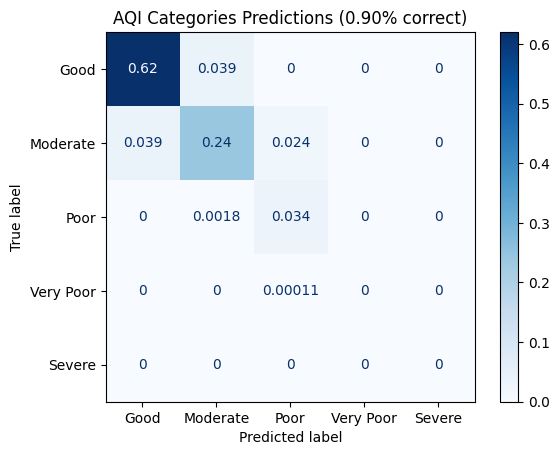

---------------------------------------------
> Absolute Mean AQI Difference: 7.69
> Positive Average AQI Difference: 7.52
> Negative Average AQI Difference: -7.92
> Percentage of Positive Differences: 55.97%
> Percentage of Negative Differences: 43.82%
> Percentage of Agent Values:
   - Same agent: 88.39
   - Different agents: 11.61
Station PORTA SAN FELICE Hourly


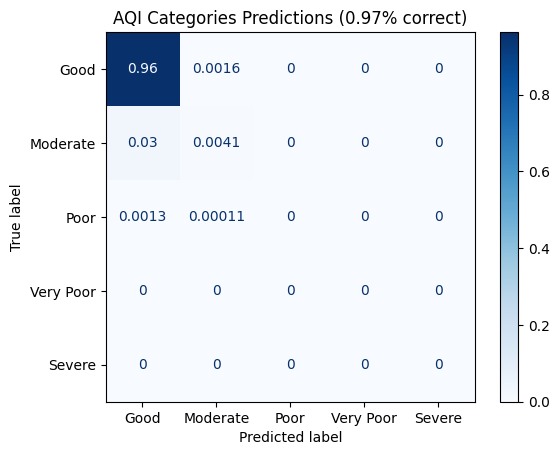

---------------------------------------------
> Absolute Mean AQI Difference: 6.61
> Positive Average AQI Difference: 6.01
> Negative Average AQI Difference: -7.73
> Percentage of Positive Differences: 64.65%
> Percentage of Negative Differences: 35.15%
> Percentage of Agent Values:
   - Same agent: 57.01
   - Different agents: 42.99
Station VIA CHIARINI Hourly


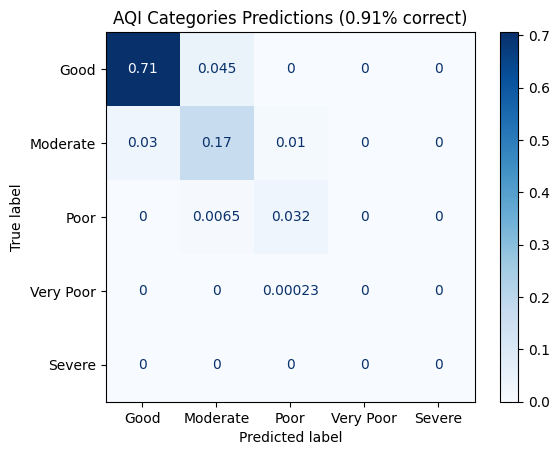

---------------------------------------------
> Absolute Mean AQI Difference: 8.13
> Positive Average AQI Difference: 8.94
> Negative Average AQI Difference: -6.97
> Percentage of Positive Differences: 58.75%
> Percentage of Negative Differences: 40.94%
> Percentage of Agent Values:
   - Same agent: 84.7
   - Different agents: 15.3
Station GIARDINI MARGHERITA Daily


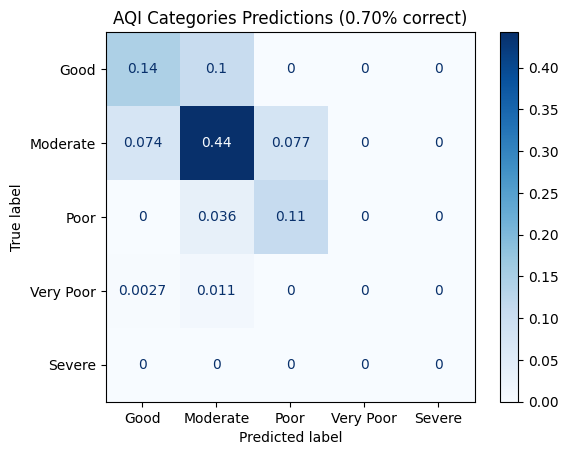

---------------------------------------------
> Absolute Mean AQI Difference: 14.25
> Positive Average AQI Difference: 13.06
> Negative Average AQI Difference: -15.78
> Percentage of Positive Differences: 56.01%
> Percentage of Negative Differences: 43.99%
> Percentage of Agent Values:
   - Same agent: 73.77
   - Different agents: 26.23
Station PORTA SAN FELICE Daily


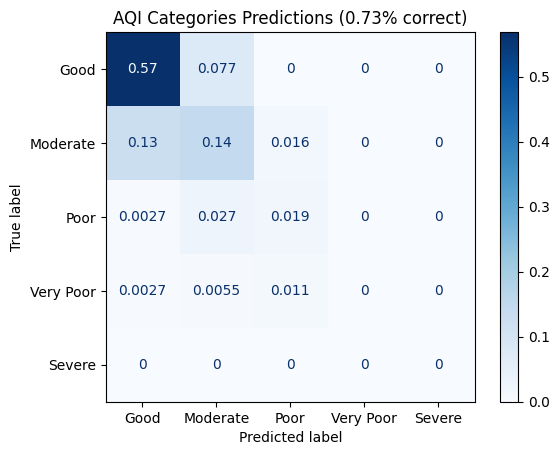

---------------------------------------------
> Absolute Mean AQI Difference: 14.83
> Positive Average AQI Difference: 11.58
> Negative Average AQI Difference: -18.96
> Percentage of Positive Differences: 56.01%
> Percentage of Negative Differences: 43.99%
> Percentage of Agent Values:
   - Same agent: 85.79
   - Different agents: 14.21
Station VIA CHIARINI Daily


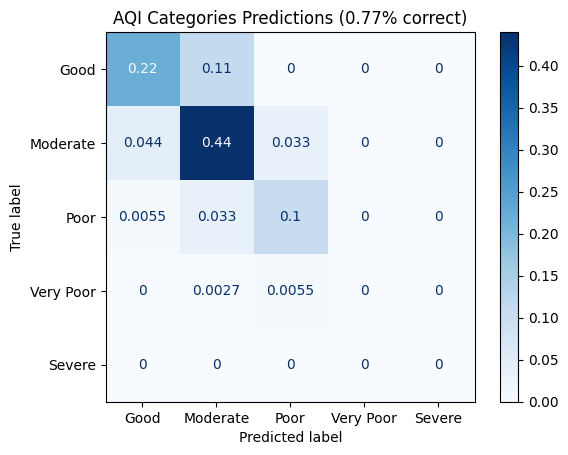

---------------------------------------------
> Absolute Mean AQI Difference: 12.21
> Positive Average AQI Difference: 11.33
> Negative Average AQI Difference: -13.54
> Percentage of Positive Differences: 59.84%
> Percentage of Negative Differences: 40.16%
> Percentage of Agent Values:
   - Same agent: 86.89
   - Different agents: 13.11


In [ ]:
compute_AQI_and_show_analysis(agents_predictions_informative, test_sets_informative)